# Depth-integrated KE in NW2

In [1]:
import xarray as xr

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cmocean
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'large',
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large',
         'font.size': 20}
pylab.rcParams.update(params)

In [3]:
import warnings
warnings.filterwarnings("ignore")

## Open NW2 data

In [4]:
exp_list = [
    r'a) $1/4^\circ$', 
    r'b) $1/8^\circ$', 
    r'c) $1/16^\circ$', 
    r'd) $1/32^\circ$'
]

degree_list = [1/4, 1/8, 1/16, 1/32]

run_list = [
    'baselines/nw2_0.25deg_N15_baseline_hmix5',
    'baselines/nw2_0.125deg_N15_baseline_hmix5',
    'baselines/nw2_0.0625deg_N15_baseline_hmix5',
    'baselines/nw2_0.03125deg_N15_baseline_hmix5'
]

In [5]:
%%time

chunks = {'time': 1}
path = '/glade/p/univ/unyu0004/gmarques/NeverWorld2'

st_list = []
av_list = []
sn_list = []

for run in run_list:
    st = xr.open_dataset('%s/%s/static.nc' % (path, run), decode_times=False)
    st_list.append(st)

    av = xr.open_mfdataset('%s/%s/averages_*.nc' % (path, run), decode_times=False, chunks=chunks, combine='by_coords')
    av_list.append(av)
    
    sn = xr.open_mfdataset('%s/%s/snapshots_*.nc' % (path, run), decode_times=False, chunks=chunks, combine='by_coords')
    sn_list.append(sn)

CPU times: user 2.08 s, sys: 305 ms, total: 2.38 s
Wall time: 37.9 s


# Compute and plot KE

In [6]:
for av, sn in zip(av_list, sn_list):
    # 5 day averages
    av['hKE'] = av['h'] * av['KE']
    # snapshots
    sn['hKE'] = sn['h'] * sn['KE']

In [7]:
from dask.diagnostics import ProgressBar

### Snapshots

[########################################] | 100% Completed |  0.3s
[########################################] | 100% Completed |  0.4s
[########################################] | 100% Completed |  0.9s
[########################################] | 100% Completed |  2.5s


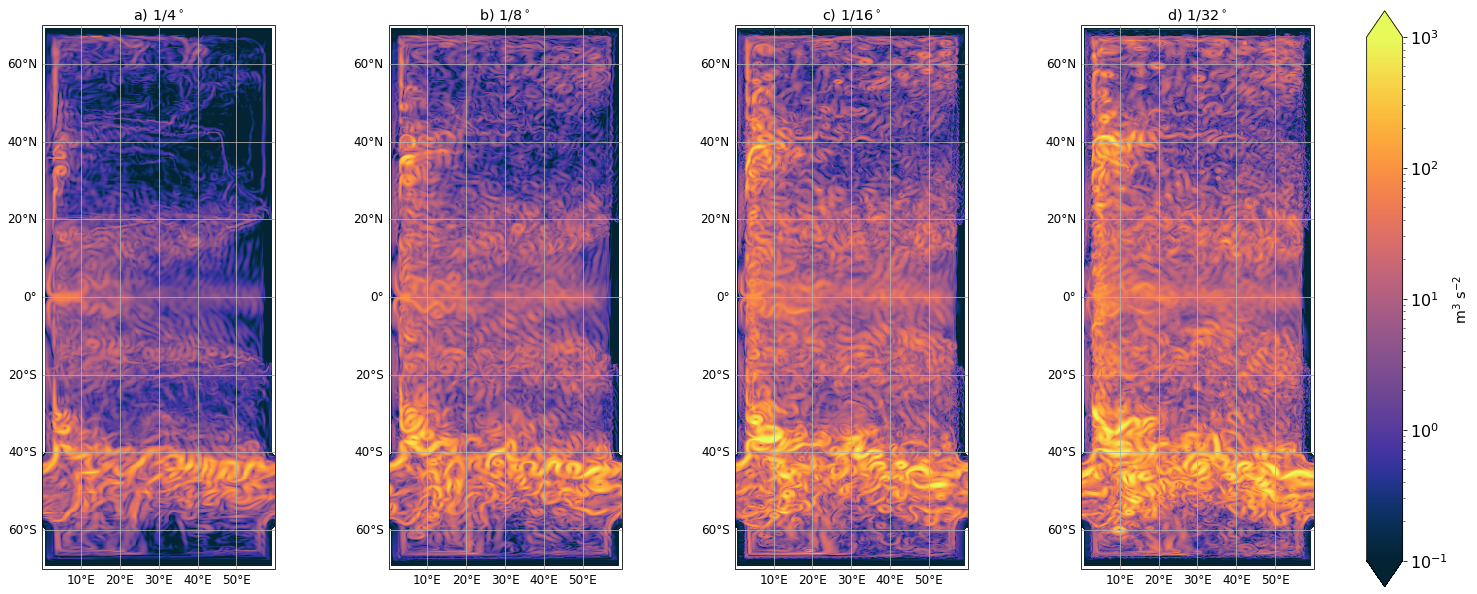

In [114]:
# snapshots
time = -1  # plot last snapshot that is available

vmin = 1e-1
vmax = 1e3
unit = r'm$^3$ s$^{-2}$'

fig,axs = plt.subplots(1,4,figsize=(25,10),subplot_kw={'projection':ccrs.PlateCarree()})

for exp, sn, ax in zip(exp_list, av_list, axs.flatten()):
    with ProgressBar():
        KE_snapshot = sn['hKE'].isel(time=time).sum(dim='zl').compute()

    p = KE_snapshot.plot(
        ax=ax,
        norm=mpl.colors.LogNorm(vmin=vmin, vmax=vmax),
        cmap=cmocean.cm.thermal,
        transform=ccrs.PlateCarree(),
        add_colorbar=False
    )

    ax.set(title=exp)
    ax.set_extent([0, 60, -70, 70], crs=ccrs.PlateCarree())
    gl = ax.gridlines(draw_labels=True)
    gl.xlabels_top = False
    gl.ylabels_right = False
    
fig.subplots_adjust(right=0.85, wspace=0.3, hspace=0.3)
cax = fig.add_axes([0.87, 0.1, 0.02, 0.8])
cbar = plt.colorbar(p, cax=cax, label=unit, extend='both')
cbar.ax.tick_params(labelsize=16) 

#fig.suptitle(r'Snapshots of depth-integrated kinetic energy = $\frac{1}{2} \sum_{n=1}^N h_n (u_n^2 + v_n^2)$', y=1.05)
plt.savefig('figures/depth_integrated_KE_snapshots.png', dpi=200,bbox_inches='tight',pad_inches=0)

### 5-day averages

[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.3s
[########################################] | 100% Completed |  0.9s
[########################################] | 100% Completed |  2.4s


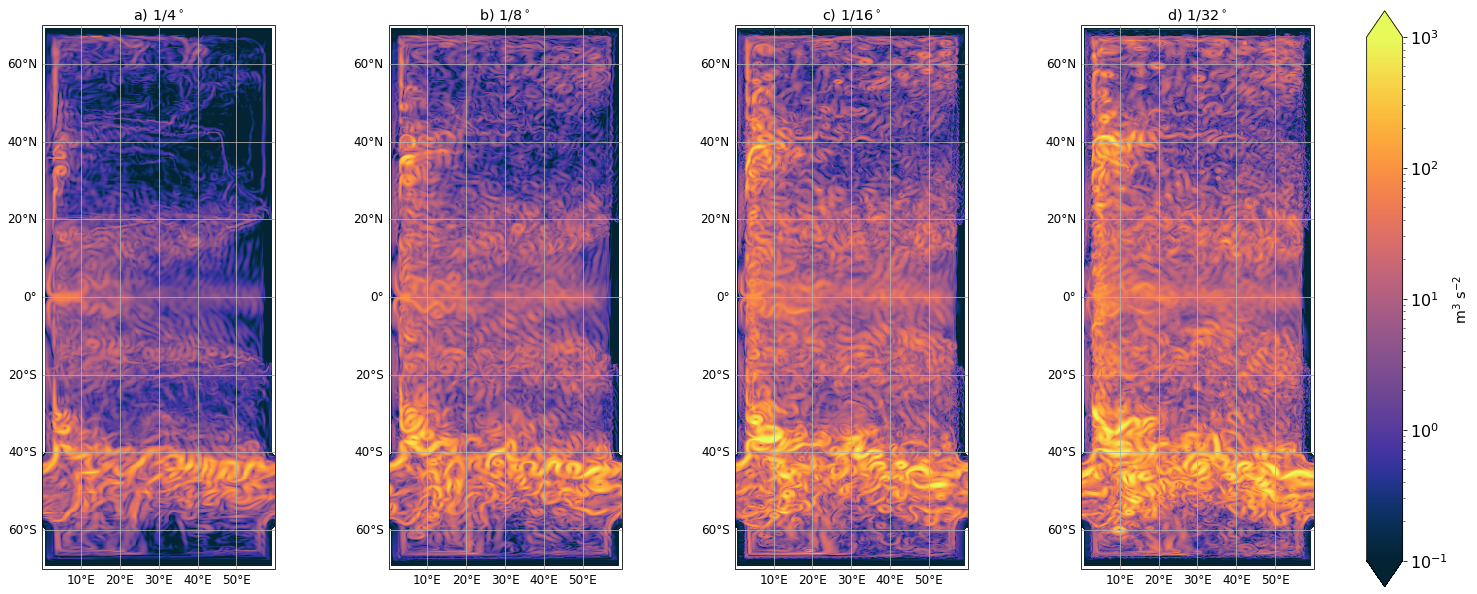

In [115]:
# 5 day averages
time = -1  # plot last 5-day average that is available

vmin = 1e-1
vmax = 1e3
unit = r'm$^3$ s$^{-2}$'

fig,axs = plt.subplots(1,4,figsize=(25,10),subplot_kw={'projection':ccrs.PlateCarree()})

for exp, av, ax in zip(exp_list, av_list, axs.flatten()):
    with ProgressBar():
        KE_5day = av['hKE'].isel(time=time).sum(dim='zl').compute()
        
    p = KE_5day.plot(
        ax=ax,
        norm=mpl.colors.LogNorm(vmin=vmin, vmax=vmax),
        cmap=cmocean.cm.thermal,
        transform=ccrs.PlateCarree(),
        add_colorbar=False
    )

    ax.set(title=exp)
    ax.set_extent([0, 60, -70, 70], crs=ccrs.PlateCarree())
    gl = ax.gridlines(draw_labels=True)
    gl.xlabels_top = False
    gl.ylabels_right = False
    
fig.subplots_adjust(right=0.85, wspace=0.3, hspace=0.3)
cax = fig.add_axes([0.87, 0.1, 0.02, 0.8])
cbar = plt.colorbar(p, cax=cax, label=unit, extend='both')
cbar.ax.tick_params(labelsize=16) 

#fig.suptitle(r'5-day averages of depth-integrated kinetic energy = $\frac{1}{2} \sum_{n=1}^N h_n (u_n^2 + v_n^2)$', y=1.05)
plt.savefig('figures/depth_integrated_KE_5day_avg.png', dpi=200,bbox_inches='tight',pad_inches=0)

### 500-day averages

[########################################] | 100% Completed | 14.6s
[########################################] | 100% Completed | 33.9s
[########################################] | 100% Completed |  1min 24.4s
[########################################] | 100% Completed |  4min 26.2s


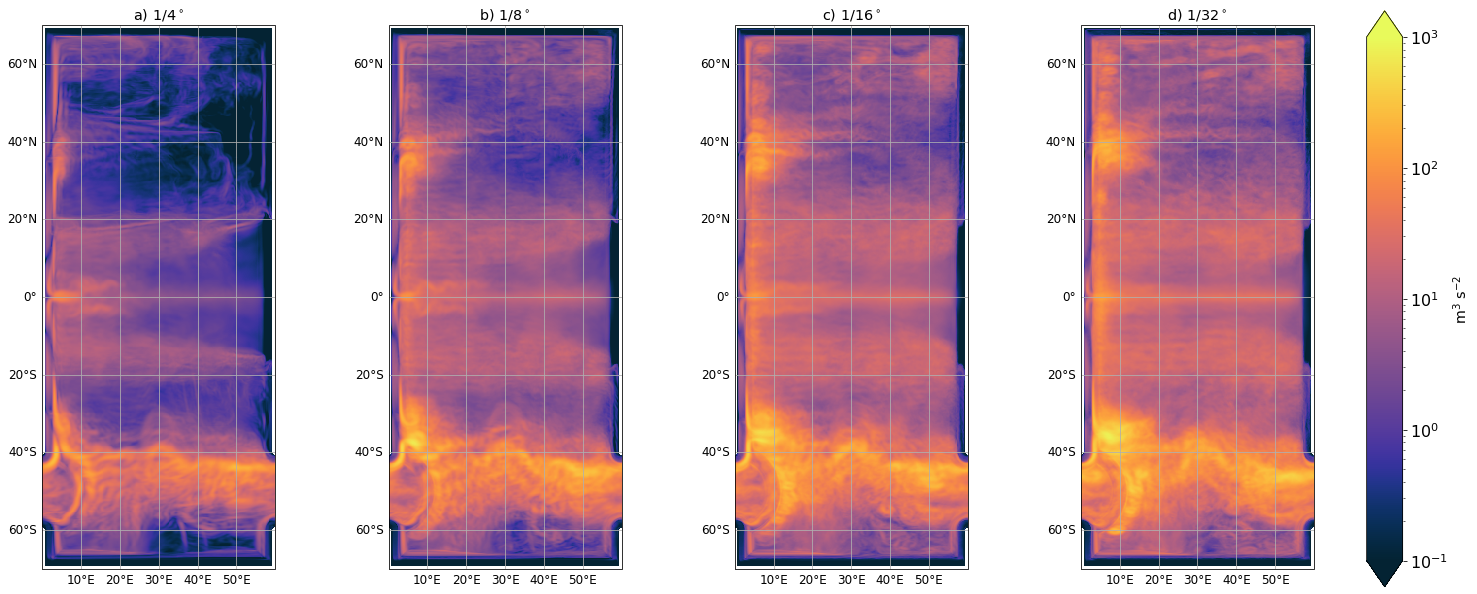

In [116]:
# 500-day averages
timeslice = slice(-100, None)  # plot average over last 500 days that are available

vmin = 1e-1
vmax = 1e3
unit = r'm$^3$ s$^{-2}$'

fig,axs = plt.subplots(1,4,figsize=(25,10),subplot_kw={'projection':ccrs.PlateCarree()})

for exp, av, st, ax in zip(exp_list, av_list, st_list, axs.flatten()):
    with ProgressBar():
        KE_500day = av['hKE'].sum(dim='zl').isel(time=timeslice).mean(dim='time').compute()
        
    # domain integral in PJ = 10^15 J = 10^15 kg*m^2/s^2; convert m^5/s^2 to J using reference density of 1000kg/m^3
    domain_integral = (KE_500day * st.area_t).sum(dim=['yh', 'xh']) * 1000 / 1e15

    p = KE_500day.plot(
        ax=ax,
        norm=mpl.colors.LogNorm(vmin=vmin, vmax=vmax),
        cmap=cmocean.cm.thermal,
        transform=ccrs.PlateCarree(),
        add_colorbar=False
    )

    ax.set(title=exp)
    ax.set_extent([0, 60, -70, 70], crs=ccrs.PlateCarree())
    gl = ax.gridlines(draw_labels=True)
    gl.xlabels_top = False
    gl.ylabels_right = False
    
    #ax.text(30, -90, r'$\int\int [\cdot] dx dy$ = %i PJ' %domain_integral.round(), horizontalalignment='center')
    
fig.subplots_adjust(right=0.85, wspace=0.3, hspace=0.3)
cax = fig.add_axes([0.87, 0.1, 0.02, 0.8])
cbar = plt.colorbar(p, cax=cax, label=unit, extend='both')
cbar.ax.tick_params(labelsize=16) 

#fig.suptitle(r'500-day averages of depth-integrated kinetic energy = $\frac{1}{2} \sum_{n=1}^N h_n (u_n^2 + v_n^2)$', y=1.05)
plt.savefig('figures/depth_integrated_KE_500day_avg.png', dpi=200,bbox_inches='tight',pad_inches=0)